## Initial setup

In [ ]:
!pip install -U -qq git+https://github.com/huggingface/diffusers.git
!pip install -qq accelerate tensorboard transformers ftfy gradio
!pip install -qq "ipywidgets>=7,<8"
!pip install -qq bitsandbytes

In [2]:
from huggingface_hub import notebook_login
!git config --global credential.helper store

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
%%time
# The xformers wheel are taken from TheLastBen/fast-stable-diffusion.
!pip install -U --pre triton

from subprocess import getoutput
from IPython.display import HTML
from IPython.display import clear_output
import time

s = getoutput('nvidia-smi')
if 'T4' in s:
  gpu = 'T4'
elif 'P100' in s:
  gpu = 'P100'
elif 'V100' in s:
  gpu = 'V100'
elif 'A100' in s:
  gpu = 'A100'

while True:
    try: 
        gpu=='T4'or gpu=='P100'or gpu=='V100'or gpu=='A100'
        break
    except:
        pass
    print('[1;31mit seems that your GPU is not supported at the moment')
    time.sleep(5)

if (gpu=='T4'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl
  
elif (gpu=='P100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/P100/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='V100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/V100/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='A100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/A100/xformers-0.0.13.dev0-py3-none-any.whl

In [3]:
import argparse
import itertools
import math
import os
from contextlib import nullcontext
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

import bitsandbytes as bnb

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Settings for teaching your new concept

In [19]:
#Specify pretrained checkpoint

pretrained_model_name_or_path = "stabilityai/stable-diffusion-2" 

In [20]:
## Give images urls for the concept you want to teach the model -- Add images of Pink Floyd's Division Bell Album Cover Here

urls = [
      "https://i.scdn.co/image/ab67616d0000b2738431fb4cb38f8ee96d3434c0",
      "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT6SNqfZJLVfRtQ1Ll_HJSd0bB-BbGWAs8ddg&usqp=CAU",
      "https://i.pinimg.com/originals/52/5e/e1/525ee1bbd5c60555d8f3dd58b4e99f30.jpg",
      "https://rukminim1.flixcart.com/image/416/416/poster/9/w/h/shoping-inc-pink-floyd-the-division-bell-psychedelic-rock-band-original-imaeev8sjfqs3td9.jpeg?q=70",
      "https://images-na.ssl-images-amazon.com/images/I/51jpjN6k+CL.jpg",
      "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQOou7dEluB5TNgf7x2PSvdUuscRTtydR8vfg&usqp=CAU",
      "https://c4.wallpaperflare.com/wallpaper/235/670/510/pink-floyd-the-division-bell-sculpture-metal-symmetry-nature-road-field-trees-clouds-evening-artwork-wallpaper-preview.jpg",
      ## You can add additional images here
      ]



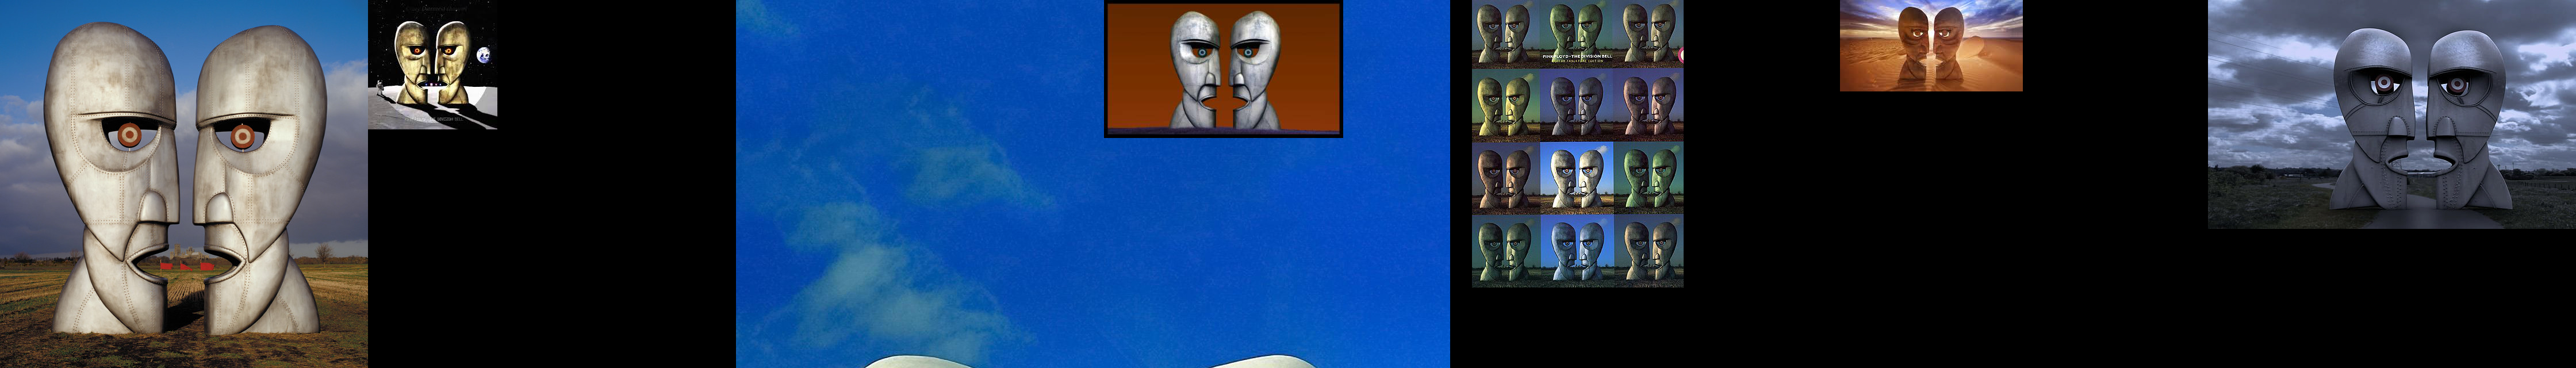

In [10]:
## Download images using urls specified on top

import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

images = list(filter(None,[download_image(url) for url in urls]))
save_path = "./my_concept"
if not os.path.exists(save_path):
  os.mkdir(save_path)
[image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]
image_grid(images, 1, len(images))

In [21]:
#`instance_prompt` is a prompt that should contain a good description of what your object or style is, together with the initializer word `cat_toy`  
instance_prompt = "pink floyd division bell album cover"
# Check the `prior_preservation` option if you would like class of the concept (e.g.: toy, dog, painting) is guaranteed to be preserved. 
#This increases the quality and helps with generalization at the cost of training time
prior_preservation = False 
prior_preservation_class_prompt = "Pink Floyd Album Cover"

num_class_images = 12 
sample_batch_size = 1
prior_loss_weight = 0.5
prior_preservation_class_folder = "./class_images"
class_data_root=prior_preservation_class_folder
class_prompt=prior_preservation_class_prompt

#### Advanced settings for prior preservation (optional)

In [22]:
num_class_images = 12 
sample_batch_size = 1
#`prior_preservation_weight` determins how strong the class for prior preservation should be 
prior_loss_weight = 1 

# If the `prior_preservation_class_folder` is empty, images for the class will be generated with the class prompt. 
#Otherwise, fill this folder with images of items on the same class as your concept (but not images of the concept itself)
prior_preservation_class_folder = "./class_images" 
class_data_root=prior_preservation_class_folder

## Teach the model the new concept (fine-tuning with Dreambooth)
Execute this this sequence of cells to run the training process. The whole process may take from 15 min to 2 hours. (Open this block if you are interested in how this process works under the hood or if you want to change advanced training settings or hyperparameters)

In [23]:
## Create DreamBooth and Prompt Dataset classes

from pathlib import Path
from torchvision import transforms

class DreamBoothDataset(Dataset):
    def __init__(
        self,
        instance_data_root,
        instance_prompt,
        tokenizer,
        class_data_root=None,
        class_prompt=None,
        size=512,
        center_crop=False,
    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer

        self.instance_data_root = Path(instance_data_root)
        if not self.instance_data_root.exists():
            raise ValueError("Instance images root doesn't exists.")

        self.instance_images_path = list(Path(instance_data_root).iterdir())
        self.num_instance_images = len(self.instance_images_path)
        self.instance_prompt = instance_prompt
        self._length = self.num_instance_images

        if class_data_root is not None:
            self.class_data_root = Path(class_data_root)
            self.class_data_root.mkdir(parents=True, exist_ok=True)
            self.class_images_path = list(Path(class_data_root).iterdir())
            self.num_class_images = len(self.class_images_path)
            self._length = max(self.num_class_images, self.num_instance_images)
            self.class_prompt = class_prompt
        else:
            self.class_data_root = None

        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        instance_image = Image.open(self.instance_images_path[index % self.num_instance_images])
        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        example["instance_images"] = self.image_transforms(instance_image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        if self.class_data_root:
            class_image = Image.open(self.class_images_path[index % self.num_class_images])
            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
            example["class_images"] = self.image_transforms(class_image)
            example["class_prompt_ids"] = self.tokenizer(
                self.class_prompt,
                padding="do_not_pad",
                truncation=True,
                max_length=self.tokenizer.model_max_length,
            ).input_ids
        
        return example


class PromptDataset(Dataset):
    def __init__(self, prompt, num_samples):
        self.prompt = prompt
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        example = {}
        example["prompt"] = self.prompt
        example["index"] = index
        return example

In [24]:
#@title Generate Class Images
import gc
if(prior_preservation):
    class_images_dir = Path(class_data_root)
    if not class_images_dir.exists():
        class_images_dir.mkdir(parents=True)
    cur_class_images = len(list(class_images_dir.iterdir()))

    if cur_class_images < num_class_images:
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path, revision="fp16", torch_dtype=torch.float16
        ).to("cuda")
        pipeline.enable_attention_slicing()
        pipeline.set_progress_bar_config(disable=True)

        num_new_images = num_class_images - cur_class_images
        print(f"Number of class images to sample: {num_new_images}.")

        sample_dataset = PromptDataset(class_prompt, num_new_images)
        sample_dataloader = torch.utils.data.DataLoader(sample_dataset, batch_size=sample_batch_size)

        for example in tqdm(sample_dataloader, desc="Generating class images"):
            images = pipeline(example["prompt"]).images

            for i, image in enumerate(images):
                image.save(class_images_dir / f"{example['index'][i] + cur_class_images}.jpg")
        pipeline = None
        gc.collect()
        del pipeline
        with torch.no_grad():
          torch.cuda.empty_cache()

In [ ]:
#@title Load the Stable Diffusion model

# Load models and create wrapper for stable diffusion
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

In [26]:
#@title Setting up all training args

from argparse import Namespace
args = Namespace(
    pretrained_model_name_or_path=pretrained_model_name_or_path,
    resolution=vae.sample_size,
    center_crop=True,
    train_text_encoder=False,
    instance_data_dir=save_path,
    instance_prompt=instance_prompt,
    learning_rate=2e-06, #5e-06
    max_train_steps=800, #300
    save_steps=50,
    train_batch_size=2, # set to 1 if using prior preservation
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    mixed_precision="fp16", # set to "fp16" for mixed-precision training.
    gradient_checkpointing=True, # set this to True to lower the memory usage.
    use_8bit_adam=True, # use 8bit optimizer from bitsandbytes
    seed=3434554,
    with_prior_preservation=prior_preservation, 
    prior_loss_weight=prior_loss_weight,
    sample_batch_size=2,
    class_data_dir=prior_preservation_class_folder, 
    class_prompt=prior_preservation_class_prompt, 
    num_class_images=num_class_images, 
    lr_scheduler="constant",
    lr_warmup_steps=100,
    output_dir="dreambooth-concept",
)

In [27]:
#@title Training function
from accelerate.utils import set_seed
def training_function(text_encoder, vae, unet):
    logger = get_logger(__name__)

    set_seed(args.seed)

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
    )

    # Currently, it's not possible to do gradient accumulation when training two models with accelerate.accumulate
    # This will be enabled soon in accelerate. For now, we don't allow gradient accumulation when training two models.
    # TODO (patil-suraj): Remove this check when gradient accumulation with two models is enabled in accelerate.
    if args.train_text_encoder and args.gradient_accumulation_steps > 1 and accelerator.num_processes > 1:
        raise ValueError(
            "Gradient accumulation is not supported when training the text encoder in distributed training. "
            "Please set gradient_accumulation_steps to 1. This feature will be supported in the future."
        )

    vae.requires_grad_(False)
    if not args.train_text_encoder:
        text_encoder.requires_grad_(False)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        if args.train_text_encoder:
            text_encoder.gradient_checkpointing_enable()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW
    
    params_to_optimize = (
        itertools.chain(unet.parameters(), text_encoder.parameters()) if args.train_text_encoder else unet.parameters()
    )

    optimizer = optimizer_class(
        params_to_optimize,
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler.from_config(args.pretrained_model_name_or_path, subfolder="scheduler")
    
    train_dataset = DreamBoothDataset(
        instance_data_root=args.instance_data_dir,
        instance_prompt=args.instance_prompt,
        class_data_root=args.class_data_dir if args.with_prior_preservation else None,
        class_prompt=args.class_prompt,
        tokenizer=tokenizer,
        size=args.resolution,
        center_crop=args.center_crop,
    )

    def collate_fn(examples):
        input_ids = [example["instance_prompt_ids"] for example in examples]
        pixel_values = [example["instance_images"] for example in examples]

        # concat class and instance examples for prior preservation
        if args.with_prior_preservation:
            input_ids += [example["class_prompt_ids"] for example in examples]
            pixel_values += [example["class_images"] for example in examples]

        pixel_values = torch.stack(pixel_values)
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

        input_ids = tokenizer.pad(
            {"input_ids": input_ids},
            padding="max_length",
            return_tensors="pt",
            max_length=tokenizer.model_max_length
        ).input_ids

        batch = {
            "input_ids": input_ids,
            "pixel_values": pixel_values,
        }
        return batch
    
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.train_batch_size, shuffle=True, collate_fn=collate_fn
    )

    lr_scheduler = get_scheduler(
        args.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
        num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
    )

    if args.train_text_encoder:
        unet, text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, text_encoder, optimizer, train_dataloader, lr_scheduler
        )
    else:
        unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, optimizer, train_dataloader, lr_scheduler
        )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16
    
    # Move text_encode and vae to gpu.
    # For mixed precision training we cast the text_encoder and vae weights to half-precision
    # as these models are only used for inference, keeping weights in full precision is not required.
    vae.to(accelerator.device, dtype=weight_dtype)
    vae.decoder.to("cpu")
    if not args.train_text_encoder:
        text_encoder.to(accelerator.device, dtype=weight_dtype)
    
    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)
  
    # Train!
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
                timesteps = timesteps.long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                if args.with_prior_preservation:
                    # Chunk the noise and noise_pred into two parts and compute the loss on each part separately.
                    noise_pred, noise_pred_prior = torch.chunk(noise_pred, 2, dim=0)
                    target, target_prior = torch.chunk(target, 2, dim=0)

                    # Compute instance loss
                    loss = F.mse_loss(noise_pred.float(), target.float(), reduction="none").mean([1, 2, 3]).mean()

                    # Compute prior loss
                    prior_loss = F.mse_loss(noise_pred_prior.float(), target_prior.float(), reduction="mean")

                    # Add the prior loss to the instance loss.
                    loss = loss + args.prior_loss_weight * prior_loss
                else:
                    loss = F.mse_loss(noise_pred.float(), target.float(), reduction="mean")

                accelerator.backward(loss)
                
                if accelerator.sync_gradients:
                    params_to_clip = (
                        itertools.chain(unet.parameters(), text_encoder.parameters())
                        if args.train_text_encoder
                        else unet.parameters()
                    )
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

                if global_step % args.save_steps == 0:
                    if accelerator.is_main_process:
                        pipeline = StableDiffusionPipeline.from_pretrained(
                            args.pretrained_model_name_or_path,
                            unet=accelerator.unwrap_model(unet),
                            text_encoder=accelerator.unwrap_model(text_encoder),
                        )
                        save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                        pipeline.save_pretrained(save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()
    
    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline.from_pretrained(
            args.pretrained_model_name_or_path,
            unet=accelerator.unwrap_model(unet),
            text_encoder=accelerator.unwrap_model(text_encoder),
        )
        pipeline.save_pretrained(args.output_dir)

In [ ]:
#@title Run training
import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))
for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
  if param.grad is not None:
    del param.grad  # free some memory
  torch.cuda.empty_cache()

## Run the code with your newly trained model
If you have just trained your model with the code above, use the block below to run it.

Also explore the [DreamBooth Concepts Library](https://huggingface.co/sd-dreambooth-library) 

In [ ]:
save_concept = True
name_of_your_concept = "sd division bell" 
where_to_save_concept = "privately_to_my_profile" 
hf_token_write = "" 


if(save_concept):
  from slugify import slugify
  from huggingface_hub import HfApi, HfFolder, CommitOperationAdd
  from huggingface_hub import create_repo
  from IPython.display import display_markdown
  api = HfApi()
  your_username = api.whoami()["name"]
  pipe = StableDiffusionPipeline.from_pretrained(
    args.output_dir,
    torch_dtype=torch.float16,
  ).to("cuda")
  os.makedirs("fp16_model",exist_ok=True)
  pipe.save_pretrained("fp16_model")

  if(where_to_save_concept == "public_library"):
    repo_id = f"sd-dreambooth-library/{slugify(name_of_your_concept)}"
    #Join the Concepts Library organization if you aren't part of it already
    !curl -X POST -H 'Authorization: Bearer '$hf_token -H 'Content-Type: application/json' https://huggingface.co/organizations/sd-dreambooth-library/share/SSeOwppVCscfTEzFGQaqpfcjukVeNrKNHX
  else:
    repo_id = f"{your_username}/{slugify(name_of_your_concept)}"
  output_dir = args.output_dir
  if(not hf_token_write):
    with open(HfFolder.path_token, 'r') as fin: hf_token = fin.read();
  else:
    hf_token = hf_token_write 
  
  images_upload = os.listdir("my_concept")
  image_string = ""
  #repo_id = f"sd-dreambooth-library/{slugify(name_of_your_concept)}"
  for i, image in enumerate(images_upload):
      image_string = f'''{image_string}![image {i}](https://huggingface.co/{repo_id}/resolve/main/concept_images/{image})
'''
  readme_text = f'''---
license: creativeml-openrail-m
tags:
- text-to-image
---
### {name_of_your_concept} on Stable Diffusion via Dreambooth
#### model by {api.whoami()["name"]}
This your the Stable Diffusion model fine-tuned the {name_of_your_concept} concept taught to Stable Diffusion with Dreambooth.
It can be used by modifying the `instance_prompt`: **{instance_prompt}**

You can also train your own concepts and upload them to the library by using [this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_dreambooth_training.ipynb).
And you can run your new concept via `diffusers`: [Colab Notebook for Inference](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_dreambooth_inference.ipynb), [Spaces with the Public Concepts loaded](https://huggingface.co/spaces/sd-dreambooth-library/stable-diffusion-dreambooth-concepts)

Here are the images used for training this concept:
{image_string}
'''
  #Save the readme to a file
  readme_file = open("README.md", "w")
  readme_file.write(readme_text)
  readme_file.close()
  #Save the token identifier to a file
  text_file = open("token_identifier.txt", "w")
  text_file.write(instance_prompt)
  text_file.close()
  operations = [
    CommitOperationAdd(path_in_repo="token_identifier.txt", path_or_fileobj="token_identifier.txt"),
    CommitOperationAdd(path_in_repo="README.md", path_or_fileobj="README.md"),
  ]
  create_repo(repo_id,private=True, token=hf_token)
  
  api.create_commit(
    repo_id=repo_id,
    operations=operations,
    commit_message=f"Upload the concept {name_of_your_concept} embeds and token",
    token=hf_token
  )
  api.upload_folder(
    folder_path="fp16_model",
    path_in_repo="",
    repo_id=repo_id,
    token=hf_token
  )
  api.upload_folder(
    folder_path=save_path,
    path_in_repo="concept_images",
    repo_id=repo_id,
    token=hf_token
  )
display_markdown(f'''## Your concept was saved successfully. [Click here to access it](https://huggingface.co/{repo_id})
''', raw=True)

In [4]:
#@title Set up the pipeline 
from torch import autocast
from diffusers import StableDiffusionPipeline
import torch

model_id = "shivi/sd-division-bell" 
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

Downloading:   0%|          | 0.00/542 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/317 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/706 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/910 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/698 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

  0%|          | 0/25 [00:00<?, ?it/s]

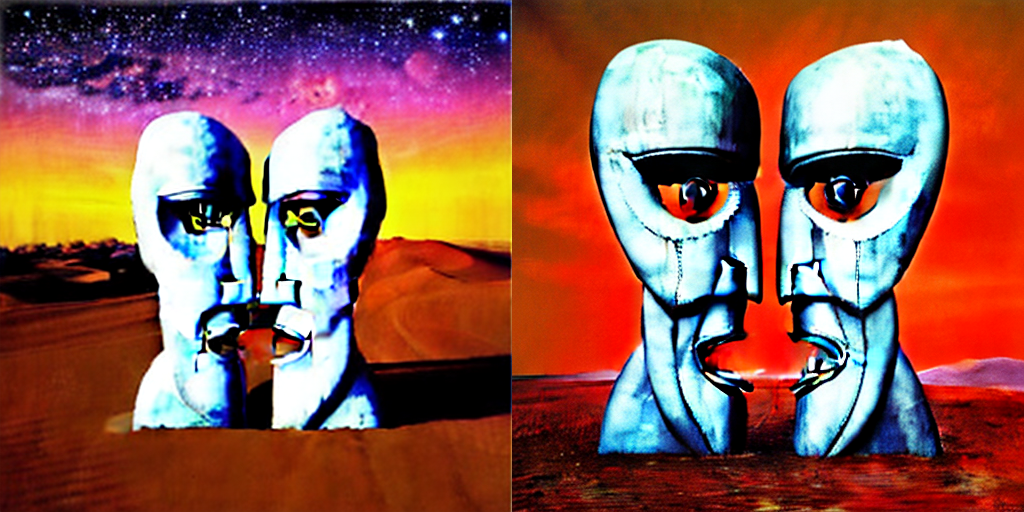

In [5]:
## Perform Inference

prompt = "picture of sks pink floyd division bell album cover on a starry night sky on mars" 

num_samples = 2 
num_rows = 1 

all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=25, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid